<a href="https://colab.research.google.com/github/PJ-Caleon/LBYCPC4/blob/main/quiz1_CPECOG3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Denoising Autoencoder**
*   Philip Jeremiah Caleon
*   12013544

Download this link:
[Image](https://drive.google.com/file/d/1TLYDxKhdD-DJhQ805iIfs6V_e8vZblwU/view)

# Extracting Image

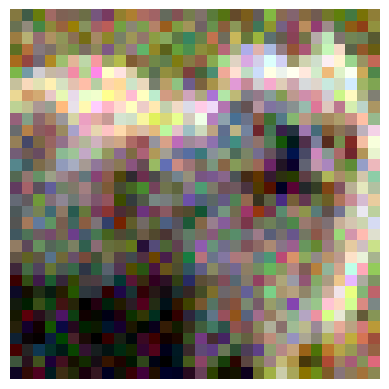

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to your PNG file
img_path = "/content/noisy_image3.png"

# Open the image
img = Image.open(img_path)

# Display with matplotlib
plt.imshow(img)
plt.axis("off")
plt.show()


# Import

In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# Preprocess data

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


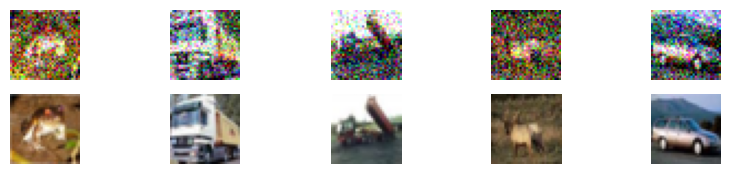

In [3]:
# Load CIFAR-10
(x_train, _), (x_test, _) = cifar10.load_data()

# Select subset
x_subset = x_train[:5000]

# Normalize to 0–1
x_subset = x_subset.astype("float32") / 255.0
x_test   = x_test.astype("float32") / 255.0

# Add synthetic noise to the images
noise_factor = 0.2
x_subset_noisy = x_subset + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_subset.shape)
x_test_noisy   = x_test   + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values to stay in [0,1]
x_subset_noisy = np.clip(x_subset_noisy, 0., 1.)
x_test_noisy   = np.clip(x_test_noisy, 0., 1.)

# Show a few noisy vs clean pairs
plt.figure(figsize=(10, 2))
for i in range(5):
    # Noisy image
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(x_subset_noisy[i])
    plt.axis("off")

    # Clean image
    ax = plt.subplot(2, 5, i+1+5)
    plt.imshow(x_subset[i])
    plt.axis("off")
plt.show()

# Model

In [4]:
# input layer

from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras import layers, models

# Create the autoencoder model based from the illustrated model plot
# Save the model as autoencoder_cnn variable
### --YOUR CODE HERE-- ###
input_img = layers.Input(shape=(32,32,3))

In [5]:
## Encoder
x1 = Conv2D(32, (3,3), strides=2, padding='same')(input_img)  # downsample
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)

x2 = Conv2D(64, (3,3), strides=2, padding='same')(x1)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)

x3 = Conv2D(128, (3,3), strides=2, padding='same')(x2)
x3 = BatchNormalization()(x3)
x3 = ReLU()(x3)

x4 = Conv2D(256, (3,3), strides=2, padding='same')(x3)
x4 = BatchNormalization()(x4)
x4 = ReLU()(x4)

# Bottleneck
bottleneck = Conv2D(256, (3,3), padding='same')(x4)
bottleneck = BatchNormalization()(bottleneck)
bottleneck = ReLU()(bottleneck)

In [6]:
## Decoder (mirroring encoder with skip connections)
d1 = Conv2DTranspose(256, (3,3), strides=2, padding='same')(bottleneck)
d1 = BatchNormalization()(d1)
d1 = ReLU()(d1)
d1 = Concatenate()([d1, x3])   # skip connection

d2 = Conv2DTranspose(128, (3,3), strides=2, padding='same')(d1)
d2 = BatchNormalization()(d2)
d2 = ReLU()(d2)
d2 = Concatenate()([d2, x2])

d3 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(d2)
d3 = BatchNormalization()(d3)
d3 = ReLU()(d3)
d3 = Concatenate()([d3, x1])

d4 = Conv2DTranspose(32, (3,3), strides=2, padding='same')(d3)
d4 = BatchNormalization()(d4)
d4 = ReLU()(d4)

# Output
decoded = Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')(d4)

In [7]:
autoencoder_cnn = models.Model(input_img, decoded)
autoencoder_cnn.compile(optimizer="adam", loss="mse")
autoencoder_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 2, 2, 256) │    295,168 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 2, 2, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 2, 2, 256) │    590,080 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 2, 2, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 4, 4, 256) │    590,080 │ re_lu_4[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 4, 4, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 384) │          0 │ re_lu_5[0][0],  

 Total params: 2,155,139 (8.22 MB)

 Trainable params: 2,152,707 (8.21 MB)

 Non-trainable params: 2,432 (9.50 KB)

# Training

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist_autoencoder_cnn = autoencoder_cnn.fit(
    x_subset_noisy, x_subset,   # train noisy → train clean
    epochs=50,
    batch_size=100,
    validation_data=(x_test_noisy, x_test),  # test noisy → test clean
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/5
50/50 - 17s - 344ms/step - loss: 0.0167 - val_loss: 0.0464
Epoch 2/5
50/50 - 1s - 26ms/step - loss: 0.0071 - val_loss: 0.0376
Epoch 3/5
50/50 - 1s - 26ms/step - loss: 0.0060 - val_loss: 0.0291
Epoch 4/5
50/50 - 1s - 28ms/step - loss: 0.0056 - val_loss: 0.0224
Epoch 5/5
50/50 - 2s - 50ms/step - loss: 0.0052 - val_loss: 0.0161


# Output

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


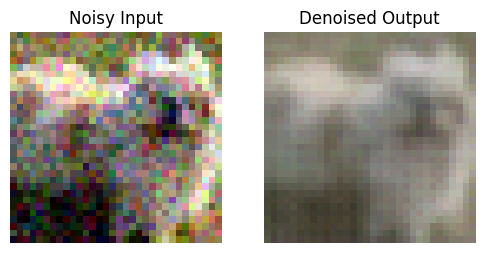

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array

# Load and preprocess the noisy image
img = Image.open(img_path).convert("RGB")   # ensure RGB
img = img.resize((32, 32))                  # resize to CIFAR-10 size
img_array = img_to_array(img).astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Run the image through the trained autoencoder
denoised_img = autoencoder_cnn.predict(img_array)

# Remove batch dimension for display
denoised_img = np.squeeze(denoised_img, axis=0)

# Plot original vs denoised
plt.figure(figsize=(6,3))

# Original noisy
plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title("Noisy Input")
plt.axis("off")

# Denoised output
plt.subplot(1, 2, 2)
plt.imshow(denoised_img)
plt.title("Denoised Output")
plt.axis("off")

plt.show()